In [1]:
import pandas as pd

df = pd.read_csv("../data/processed/clean_ecommerce.csv")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


In [2]:
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [3]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (reference_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPrice": "sum"
}).reset_index()


In [4]:
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]


In [5]:
rfm.head()
rfm.describe()


,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


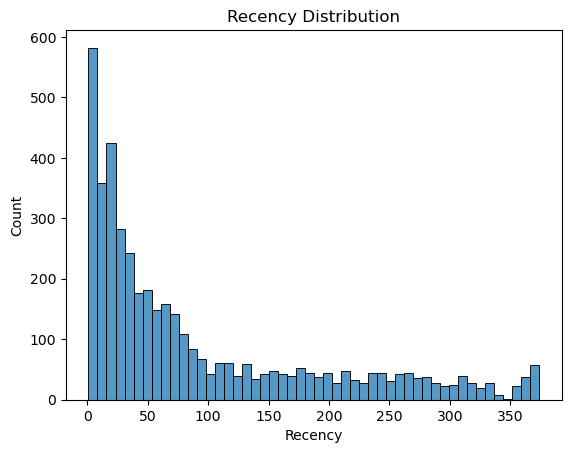

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(rfm["Recency"], bins=50)
plt.title("Recency Distribution")
plt.show()


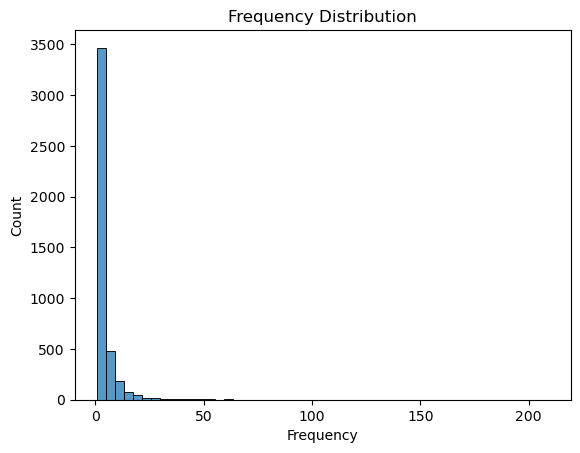

In [7]:
sns.histplot(rfm["Frequency"], bins=50)
plt.title("Frequency Distribution")
plt.show()


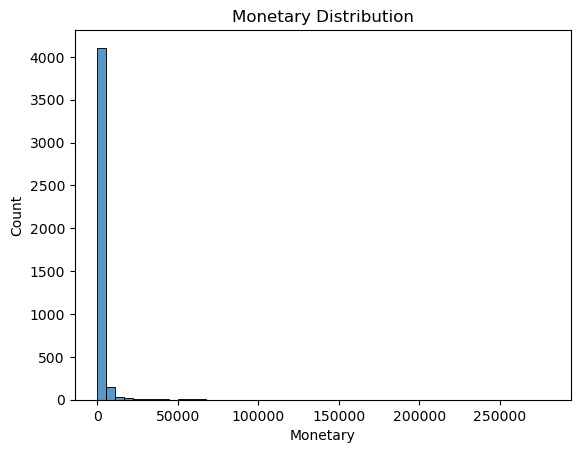

In [8]:
sns.histplot(rfm["Monetary"], bins=50)
plt.title("Monetary Distribution")
plt.show()


Recency Score (Lower is better → reverse)

In [9]:
rfm["R_Score"] = pd.qcut(
    rfm["Recency"], 
    q=5, 
    labels=[5, 4, 3, 2, 1]
)


Frequency Score (Higher is better)

In [10]:
rfm["F_Score"] = pd.qcut(
    rfm["Frequency"].rank(method="first"), 
    q=5, 
    labels=[1, 2, 3, 4, 5]
)


Monetary Score (Higher is better)

In [11]:
rfm["M_Score"] = pd.qcut(
    rfm["Monetary"], 
    q=5, 
    labels=[1, 2, 3, 4, 5]
)


In [12]:
rfm[["R_Score", "F_Score", "M_Score"]] = rfm[
    ["R_Score", "F_Score", "M_Score"]
].astype(int)


In [13]:
rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)


Define Customer Segments (Business Logic)

In [14]:
def segment_customer(row):
    if row["R_Score"] >= 4 and row["F_Score"] >= 4 and row["M_Score"] >= 4:
        return "Champions"
    elif row["R_Score"] >= 3 and row["F_Score"] >= 3:
        return "Loyal Customers"
    elif row["R_Score"] >= 4 and row["F_Score"] <= 2:
        return "Potential Loyalists"
    elif row["R_Score"] <= 2 and row["F_Score"] >= 3:
        return "At Risk"
    elif row["R_Score"] == 1:
        return "Lost Customers"
    else:
        return "Others"


In [15]:
rfm["Segment"] = rfm.apply(segment_customer, axis=1)


In [16]:
rfm["Segment"].value_counts()


Segment
Loyal Customers        998
Champions              962
Others                 752
Lost Customers         664
At Risk                643
Potential Loyalists    319
Name: count, dtype: int64

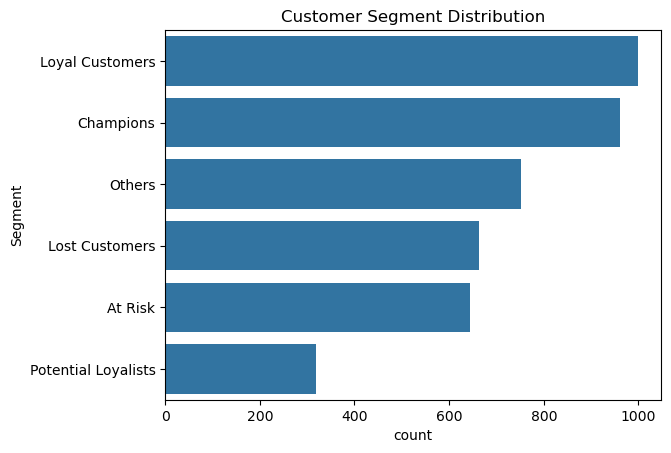

In [17]:
sns.countplot(
    y="Segment",
    data=rfm,
    order=rfm["Segment"].value_counts().index
)
plt.title("Customer Segment Distribution")
plt.show()


In [18]:
rfm.to_csv("../data/processed/rfm_segments.csv", index=False)
